In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 10


In [2]:
df = pd.read_csv(Path('../data/PRSA_data_2010.1.1-2014.12.31_Beijing.csv'))

In [9]:
# Funzione per identificare sequenze continue senza missing
def find_continuous_sequences(series, min_length=100):
    """
    Identifica sequenze continue di valori non-missing di lunghezza >= min_length.
    
    Parameters:
    -----------
    series : pd.Series
        Serie temporale da analizzare
    min_length : int
        Lunghezza minima della sequenza continua
    
    Returns:
    --------
    list of tuples : [(start_idx, end_idx, length), ...]
        Lista di tuple con indici di inizio, fine e lunghezza di ogni sequenza
    """
    sequences = []
    start_idx = None
    current_length = 0
    
    for idx in range(len(series)):
        if pd.notna(series.iloc[idx]):
            # Valore valido
            if start_idx is None:
                start_idx = idx
                current_length = 1
            else:
                current_length += 1
        else:
            # Missing value - salva sequenza se abbastanza lunga
            if start_idx is not None and current_length >= min_length:
                sequences.append((start_idx, idx - 1, current_length))
            start_idx = None
            current_length = 0
    
    # Controlla l'ultima sequenza
    if start_idx is not None and current_length >= min_length:
        sequences.append((start_idx, len(series) - 1, current_length))
    
    return sequences

# Crea indice datetime
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.set_index('datetime', inplace=True)

# Trova sequenze continue di PM2.5
min_sequence_length = 100
continuous_sequences = find_continuous_sequences(df['pm2.5'], min_length=min_sequence_length)

print(f"\n SEQUENZE CONTINUE (≥ {min_sequence_length} valori consecutivi senza missing)\n")
print("=" * 90)
print(f"{'#':<5} {'Inizio':<22} {'Fine':<22} {'Lunghezza':<12} {'% Dataset':<12}")
print("=" * 90)

total_continuous_values = 0
for i, (start_idx, end_idx, length) in enumerate(continuous_sequences, 1):
    start_date = df.index[start_idx]
    end_date = df.index[end_idx]
    pct = length / len(df) * 100
    print(f"{i:<5} {str(start_date):<22} {str(end_date):<22} {length:<12,} {pct:<12.2f}%")
    total_continuous_values += length

print("=" * 90)
print(f"\nStatistiche:")
print(f"   Numero sequenze trovate:     {len(continuous_sequences)}")
print(f"   Totale valori in sequenze:   {total_continuous_values:,}")
print(f"   % dataset utilizzabile:      {total_continuous_values/len(df)*100:.2f}%")
print(f"   Media lunghezza sequenza:    {total_continuous_values/len(continuous_sequences):.0f} valori")
print(f"   Sequenza più lunga:          {max([s[2] for s in continuous_sequences]):,} valori")
print(f"   Sequenza più corta:          {min([s[2] for s in continuous_sequences]):,} valori")


 SEQUENZE CONTINUE (≥ 100 valori consecutivi senza missing)

#     Inizio                 Fine                   Lunghezza    % Dataset   
1     2010-01-02 00:00:00    2010-01-23 16:00:00    521          1.19        %
2     2010-01-26 12:00:00    2010-02-14 01:00:00    446          1.02        %
3     2010-02-14 03:00:00    2010-03-20 04:00:00    818          1.87        %
4     2010-03-23 00:00:00    2010-03-30 05:00:00    174          0.40        %
5     2010-04-01 13:00:00    2010-05-17 16:00:00    1,108        2.53        %
6     2010-05-17 19:00:00    2010-05-27 18:00:00    240          0.55        %
7     2010-05-28 00:00:00    2010-06-01 15:00:00    112          0.26        %
8     2010-06-09 17:00:00    2010-06-20 07:00:00    255          0.58        %
9     2010-06-23 10:00:00    2010-08-13 19:00:00    1,234        2.82        %
10    2010-08-16 16:00:00    2010-09-11 05:00:00    614          1.40        %
11    2010-09-11 22:00:00    2010-09-19 18:00:00    189          0.43 

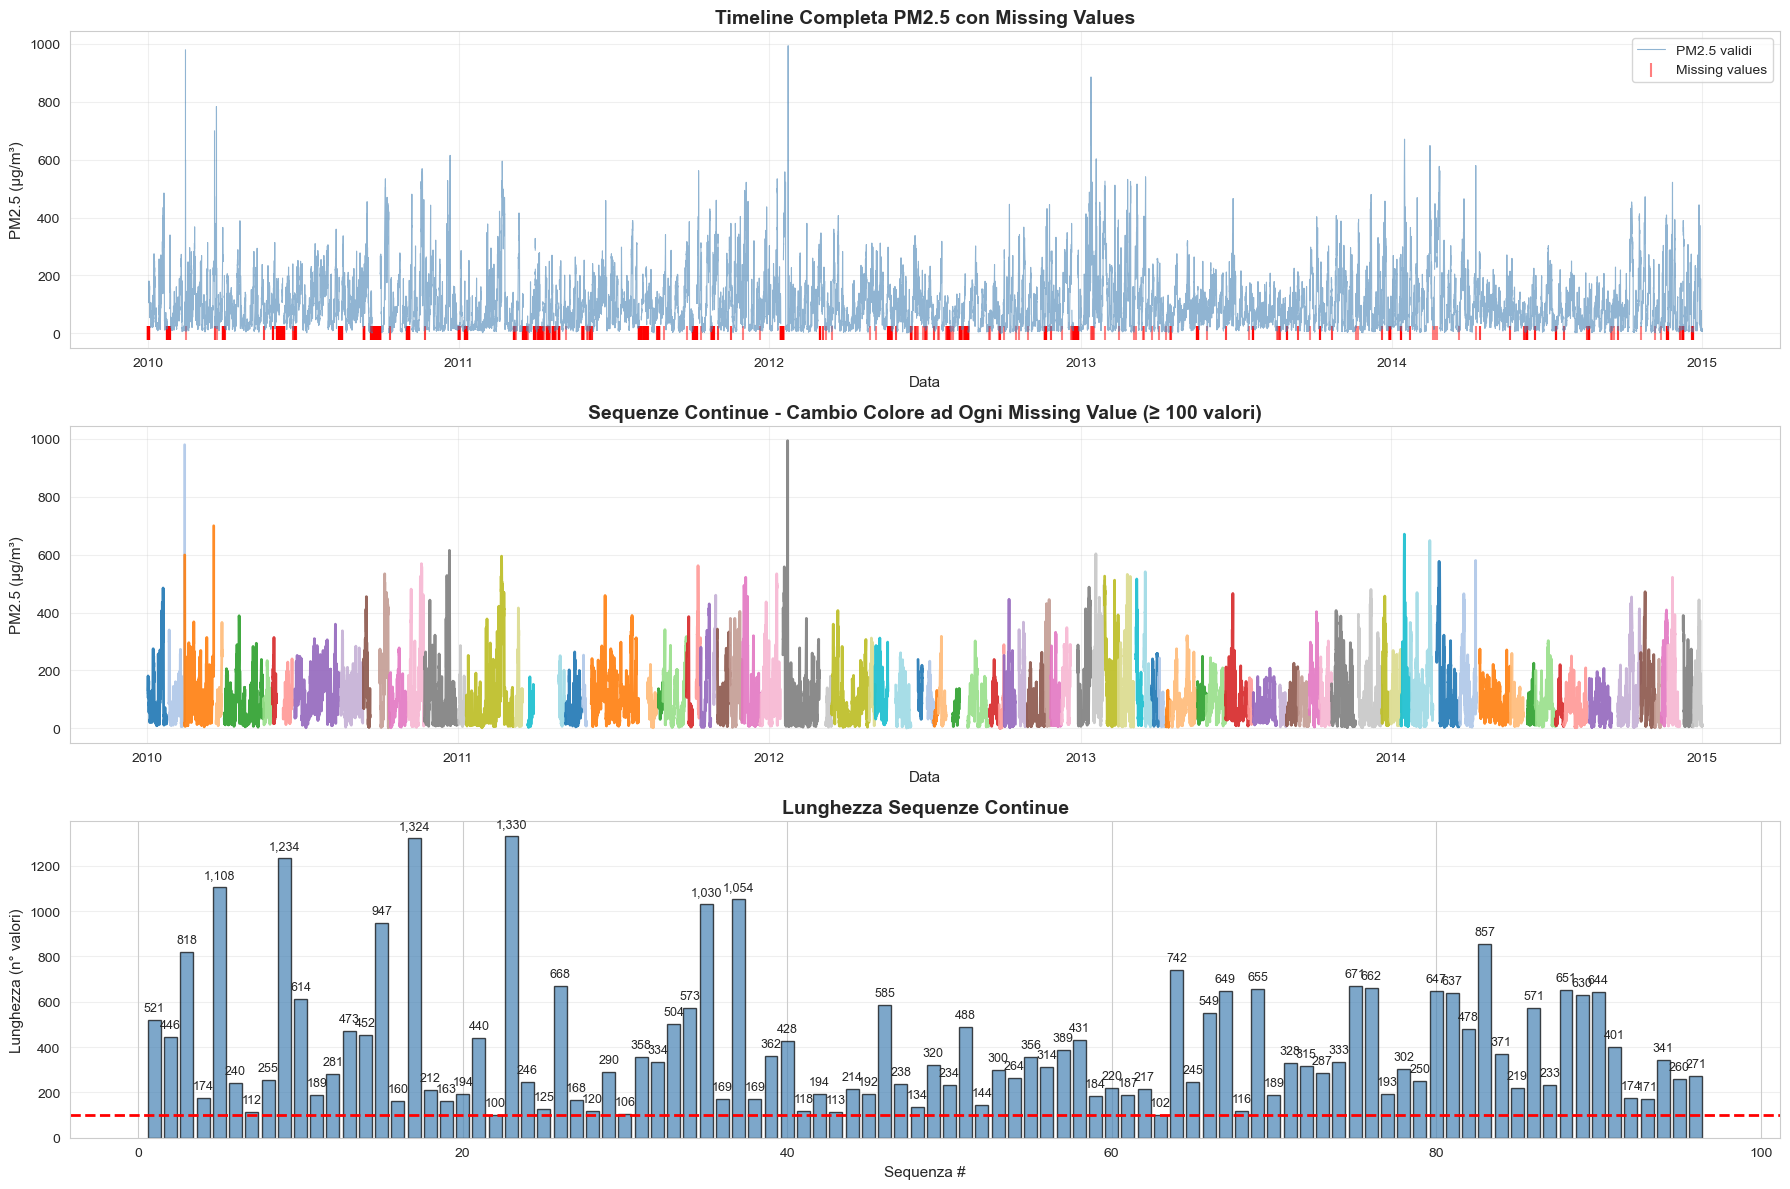

In [10]:
# Visualizzazione sequenze continue
fig, axes = plt.subplots(3, 1, figsize=(18, 12))

# 1. Timeline completa con missing values evidenziati
ax1 = axes[0]
ax1.plot(df.index, df['pm2.5'], alpha=0.6, linewidth=0.8, color='steelblue', label='PM2.5 validi')

# Evidenzia missing values
missing_mask = df['pm2.5'].isnull()
if missing_mask.any():
    missing_indices = df.index[missing_mask]
    ax1.scatter(missing_indices, [0] * len(missing_indices), 
               color='red', marker='|', s=100, alpha=0.5, label='Missing values')

ax1.set_title('Timeline Completa PM2.5 con Missing Values', fontsize=14, fontweight='bold')
ax1.set_xlabel('Data', fontsize=11)
ax1.set_ylabel('PM2.5 (μg/m³)', fontsize=11)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Sequenze continue evidenziate con cambio colore ad ogni sequenza
ax2 = axes[1]

palette = plt.cm.tab20.colors  # 20 colori distinti
n_colors = len(palette)

for i, (start_idx, end_idx, length) in enumerate(continuous_sequences):
    seq_data = df['pm2.5'].iloc[start_idx:end_idx+1]
    # Usa il modulo per ciclare sui colori
    color = palette[i % n_colors]
    ax2.plot(seq_data.index, seq_data.values, 
            linewidth=2, color=color, alpha=0.9)

ax2.set_title(f'Sequenze Continue - Cambio Colore ad Ogni Missing Value (≥ {min_sequence_length} valori)', 
             fontsize=14, fontweight='bold')
ax2.set_xlabel('Data', fontsize=11)
ax2.set_ylabel('PM2.5 (μg/m³)', fontsize=11)
ax2.grid(True, alpha=0.3)

# 3. Distribuzione lunghezze sequenze
ax3 = axes[2]
sequence_lengths = [s[2] for s in continuous_sequences]
ax3.bar(range(1, len(sequence_lengths) + 1), sequence_lengths, 
       color='steelblue', edgecolor='black', alpha=0.7)
ax3.axhline(y=min_sequence_length, color='red', linestyle='--', 
           linewidth=2, label=f'Soglia minima ({min_sequence_length})')
ax3.set_title('Lunghezza Sequenze Continue', fontsize=14, fontweight='bold')
ax3.set_xlabel('Sequenza #', fontsize=11)
ax3.set_ylabel('Lunghezza (n° valori)', fontsize=11)
#ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

# Aggiungi valori sopra le barre
for i, length in enumerate(sequence_lengths):
    ax3.text(i + 1, length + max(sequence_lengths)*0.02, 
            f'{length:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [13]:
# Estrai dati dalle sequenze continue
def extract_continuous_data(dataframe, sequences):
    """
    Estrae i dati dalle sequenze continue e li concatena.
    
    Parameters:
    -----------
    dataframe : pd.DataFrame
        DataFrame originale
    sequences : list of tuples
        Lista di sequenze (start_idx, end_idx, length)
    
    Returns:
    --------
    pd.DataFrame : DataFrame con solo le sequenze continue
    list : Lista di tuple (seq_id, start_pos, end_pos) per tracciare le sequenze
    """
    continuous_chunks = []
    sequence_info = []
    current_position = 0
    
    for seq_id, (start_idx, end_idx, length) in enumerate(sequences, 1):
        chunk = dataframe.iloc[start_idx:end_idx+1].copy()
        chunk['sequence_id'] = seq_id  # Traccia da quale sequenza proviene
        continuous_chunks.append(chunk)
        
        # Salva informazioni sulla posizione nel nuovo dataset
        sequence_info.append({
            'seq_id': seq_id,
            'original_start': start_idx,
            'original_end': end_idx,
            'new_start': current_position,
            'new_end': current_position + length - 1,
            'length': length,
            'date_start': dataframe.index[start_idx],
            'date_end': dataframe.index[end_idx]
        })
        current_position += length
    
    # Concatena tutte le sequenze
    continuous_df = pd.concat(continuous_chunks, axis=0)
    
    return continuous_df, sequence_info

# Estrai dati continui
df_continuous, seq_info = extract_continuous_data(df, continuous_sequences)

print("Dataset Continuo Estratto\n")
print("=" * 90)
print(f"Shape dataset originale:    {df.shape}")
print(f"Shape dataset continuo:     {df_continuous.shape}")
print(f"Righe mantenute:            {len(df_continuous):,} ({len(df_continuous)/len(df)*100:.2f}%)")
print("=" * 90)

print(f"\nInformazioni Sequenze nel Dataset Continuo:")
print("=" * 90)
print(f"{'Seq':<5} {'Inizio Originale':<20} {'Fine Originale':<20} {'Pos. Nuovo Dataset':<25} {'Lunghezza':<12}")
print("=" * 90)
for info in seq_info:
    pos_range = f"{info['new_start']} - {info['new_end']}"
    print(f"{info['seq_id']:<5} {str(info['date_start']):<20} {str(info['date_end']):<20} "
          f"{pos_range:<25} {info['length']:<12,}")
print("=" * 90)

# Verifica che non ci siano missing nel dataset continuo
missing_in_continuous = df_continuous['pm2.5'].isnull().sum()
print(f"\nVerifica: Missing PM2.5 nel dataset continuo: {missing_in_continuous}")

Dataset Continuo Estratto

Shape dataset originale:    (43824, 13)
Shape dataset continuo:     (38471, 14)
Righe mantenute:            38,471 (87.79%)

Informazioni Sequenze nel Dataset Continuo:
Seq   Inizio Originale     Fine Originale       Pos. Nuovo Dataset        Lunghezza   
1     2010-01-02 00:00:00  2010-01-23 16:00:00  0 - 520                   521         
2     2010-01-26 12:00:00  2010-02-14 01:00:00  521 - 966                 446         
3     2010-02-14 03:00:00  2010-03-20 04:00:00  967 - 1784                818         
4     2010-03-23 00:00:00  2010-03-30 05:00:00  1785 - 1958               174         
5     2010-04-01 13:00:00  2010-05-17 16:00:00  1959 - 3066               1,108       
6     2010-05-17 19:00:00  2010-05-27 18:00:00  3067 - 3306               240         
7     2010-05-28 00:00:00  2010-06-01 15:00:00  3307 - 3418               112         
8     2010-06-09 17:00:00  2010-06-20 07:00:00  3419 - 3673               255         
9     2010-06-23 10:0

In [14]:
# Funzione per creare finestre temporali (sliding window)
def create_sequences_from_continuous(data, sequence_info, window_size=24, forecast_horizon=1, 
                                     features=None, target='pm2.5'):
    """
    Crea finestre temporali dalle sequenze continue, rispettando i confini delle sequenze.
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame con le sequenze continue
    sequence_info : list of dict
        Informazioni sulle sequenze
    window_size : int
        Dimensione della finestra di input (numero di timesteps passati)
    forecast_horizon : int
        Orizzonte di previsione (numero di timesteps futuri da predire)
    features : list
        Lista di feature da usare (se None, usa tutte tranne target)
    target : str
        Nome della colonna target
    
    Returns:
    --------
    X : np.array
        Array di input shape (n_samples, window_size, n_features)
    y : np.array
        Array di target shape (n_samples, forecast_horizon)
    window_info : list
        Informazioni su ogni finestra (per debugging/analisi)
    """
    if features is None:
        # Usa tutte le feature tranne target e sequence_id
        features = [col for col in data.columns if col not in [target, 'sequence_id']]
    
    X_list = []
    y_list = []
    window_info = []
    
    total_windows = 0
    
    # Processa ogni sequenza separatamente
    for seq in sequence_info:
        seq_id = seq['seq_id']
        start_pos = seq['new_start']
        end_pos = seq['new_end']
        seq_length = seq['length']
        
        # Estrai dati della sequenza
        seq_data = data.iloc[start_pos:end_pos+1]
        
        # Calcola quante finestre possiamo creare da questa sequenza
        max_windows = seq_length - window_size - forecast_horizon + 1
        
        if max_windows <= 0:
            print(f"Sequenza {seq_id} troppo corta ({seq_length}) per creare finestre "
                  f"(necessari almeno {window_size + forecast_horizon})")
            continue
        
        # Crea finestre dalla sequenza
        for i in range(max_windows):
            # Finestra di input
            window_start = i
            window_end = i + window_size
            
            # Valore/i da predire
            target_start = window_end
            target_end = window_end + forecast_horizon
            
            # Estrai dati
            X_window = seq_data[features].iloc[window_start:window_end].values
            y_window = seq_data[target].iloc[target_start:target_end].values
            
            # Verifica che non ci siano NaN (controlla solo se numeric)
            has_nan = False
            try:
                has_nan = np.isnan(X_window).any() or np.isnan(y_window).any()
            except TypeError:
                # Se non è numerico, usa pandas
                has_nan = pd.isna(X_window).any() or pd.isna(y_window).any()
            
            if not has_nan:
                X_list.append(X_window)
                y_list.append(y_window)
                
                window_info.append({
                    'seq_id': seq_id,
                    'window_idx': i,
                    'global_start': start_pos + window_start,
                    'global_end': start_pos + window_end - 1,
                    'target_idx': start_pos + target_start
                })
                
                total_windows += 1
        
        print(f"✓ Sequenza {seq_id}: {max_windows:,} finestre create")
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    print(f"\nRiepilogo Windowing:")
    print(f"   Finestre totali create:  {total_windows:,}")
    print(f"   X shape:                 {X.shape} (samples, timesteps, features)")
    print(f"   y shape:                 {y.shape} (samples, forecast_horizon)")
    
    return X, y, window_info


In [15]:
# Parametri windowing
WINDOW_SIZE = 100  # Usa 100 valori precedenti di PM2.5
FORECAST_HORIZON = 1  # Predici il prossimo valore

feature_columns = ['pm2.5']  # Solo PM2.5!

In [17]:
# Crea finestre temporali
X, y, window_info = create_sequences_from_continuous(
    data=df_continuous,
    sequence_info=seq_info,
    window_size=WINDOW_SIZE,
    forecast_horizon=FORECAST_HORIZON,
    features=['pm2.5'],  # Solo PM2.5 come input!
    target='pm2.5'
)

print("=" * 90)
print(f"\nShape finali:")
print(f"   X: {X.shape} → (n_samples={X.shape[0]:,}, timesteps={X.shape[1]}, features={X.shape[2]})")
print(f"   y: {y.shape} → (n_samples={y.shape[0]:,}, forecast_horizon={y.shape[1]})")

✓ Sequenza 1: 421 finestre create
✓ Sequenza 2: 346 finestre create
✓ Sequenza 3: 718 finestre create
✓ Sequenza 4: 74 finestre create
✓ Sequenza 5: 1,008 finestre create
✓ Sequenza 6: 140 finestre create
✓ Sequenza 7: 12 finestre create
✓ Sequenza 8: 155 finestre create
✓ Sequenza 9: 1,134 finestre create
✓ Sequenza 10: 514 finestre create
✓ Sequenza 11: 89 finestre create
✓ Sequenza 12: 181 finestre create
✓ Sequenza 13: 373 finestre create
✓ Sequenza 14: 352 finestre create
✓ Sequenza 15: 847 finestre create
✓ Sequenza 16: 60 finestre create
✓ Sequenza 9: 1,134 finestre create
✓ Sequenza 10: 514 finestre create
✓ Sequenza 11: 89 finestre create
✓ Sequenza 12: 181 finestre create
✓ Sequenza 13: 373 finestre create
✓ Sequenza 14: 352 finestre create
✓ Sequenza 15: 847 finestre create
✓ Sequenza 16: 60 finestre create
✓ Sequenza 17: 1,224 finestre create
✓ Sequenza 18: 112 finestre create
✓ Sequenza 19: 63 finestre create
✓ Sequenza 20: 94 finestre create
✓ Sequenza 21: 340 finestre cr

In [27]:
# Split Train/Test a livello di sequenze intere
# Bilanciato per numero di FINESTRE (non sequenze)

# 1. Conta quante finestre ha ogni sequenza
from collections import defaultdict
windows_per_sequence = defaultdict(int)

for win_info in window_info:
    seq_id = win_info['seq_id']
    windows_per_sequence[seq_id] += 1

total_windows = len(window_info)


# 2. Assegnazione greedy delle sequenze per avvicinarsi al 70/30
target_train_windows = int(0.69 * total_windows)

# Shuffle casuale delle sequenze
np.random.seed(42)
sequence_ids = list(windows_per_sequence.keys())
np.random.shuffle(sequence_ids)

train_sequences = []
test_sequences = []
train_window_count = 0

# Assegna sequenze finché non raggiungi circa il 70%
for seq_id in sequence_ids:
    if train_window_count < target_train_windows:
        train_sequences.append(seq_id)
        train_window_count += windows_per_sequence[seq_id]
    else:
        test_sequences.append(seq_id)

print(f"\nAssegnazione sequenze in train/test:")
print(f"   Train: {len(train_sequences)} sequenze → {sorted(train_sequences)}")
print(f"   Test:  {len(test_sequences)} sequenze → {sorted(test_sequences)}")

# 3. Raccogli indici delle finestre
train_indices = []
test_indices = []

for idx, win_info in enumerate(window_info):
    if win_info['seq_id'] in train_sequences:
        train_indices.append(idx)
    else:
        test_indices.append(idx)

# 4. Estrai i dati
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

print(f"\nPercentuali finestre:")
print(f"   Train: {len(X_train):,} finestre ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Test:  {len(X_test):,} finestre ({len(X_test)/len(X)*100:.1f}%)")

# Normalizzazione
from sklearn.preprocessing import StandardScaler
# Reshape per normalizzazione
n_train_samples, n_timesteps, n_features = X_train.shape
X_train_reshaped = X_train.reshape(-1, n_features)

n_test_samples = X_test.shape[0]
X_test_reshaped = X_test.reshape(-1, n_features)

# Fit scaler solo sul training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape back
X_train_scaled = X_train_scaled.reshape(n_train_samples, n_timesteps, n_features)
X_test_scaled = X_test_scaled.reshape(n_test_samples, n_timesteps, n_features)

print(f"\nNormalizzazione:")
print(f"   X_train_scaled: {X_train_scaled.shape}")
print(f"   X_test_scaled:  {X_test_scaled.shape}")

print(f"\nStatistiche target (PM2.5):")
print(f"   Train - min: {y_train.min():.2f}, max: {y_train.max():.2f}, mean: {y_train.mean():.2f}")
print(f"   Test  - min: {y_test.min():.2f}, max: {y_test.max():.2f}, mean: {y_test.mean():.2f}")


Assegnazione sequenze in train/test:
   Train: 71 sequenze → [1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 24, 26, 27, 28, 29, 30, 32, 33, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 55, 56, 57, 58, 60, 63, 64, 66, 67, 68, 69, 70, 71, 72, 74, 75, 77, 78, 79, 80, 81, 83, 85, 86, 87, 92, 93, 95, 96]
   Test:  24 sequenze → [2, 3, 15, 21, 23, 25, 31, 34, 39, 53, 54, 59, 61, 62, 65, 73, 76, 82, 84, 88, 89, 90, 91, 94]

Percentuali finestre:
   Train: 20,010 finestre (69.3%)
   Test:  8,861 finestre (30.7%)

Normalizzazione:
   X_train_scaled: (20010, 100, 1)
   X_test_scaled:  (8861, 100, 1)

Statistiche target (PM2.5):
   Train - min: 1.00, max: 994.00, mean: 97.40
   Test  - min: 2.00, max: 980.00, mean: 98.03


In [28]:
# Install optuna for hyperparameter optimization
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate

In [29]:
# Funzione per creare il modello LSTM
def create_lstm_model(window_size, n_features, lstm_units_1, lstm_units_2, 
                      dropout_rate, learning_rate, use_second_layer=True):
    """
    Crea un modello LSTM per time series univariata.
    
    Parameters:
    -----------
    window_size : int
        Numero di timesteps nella finestra di input
    n_features : int
        Numero di features (1 per modello univariato)
    lstm_units_1 : int
        Unità nel primo layer LSTM
    lstm_units_2 : int
        Unità nel secondo layer LSTM (se usato)
    dropout_rate : float
        Rate di dropout (0.0 - 0.5)
    learning_rate : float
        Learning rate per l'ottimizzatore
    use_second_layer : bool
        Se True, usa 2 layer LSTM, altrimenti solo 1
    
    Returns:
    --------
    model : keras.Model
        Modello compilato
    """
    model = keras.Sequential(name='LSTM_PM25_Predictor')
    
    if use_second_layer:
        # Primo layer LSTM con return_sequences=True per secondo layer
        model.add(keras.layers.LSTM(
            lstm_units_1, 
            return_sequences=True,
            input_shape=(window_size, n_features),
            name='lstm_layer_1'
        ))
        model.add(keras.layers.Dropout(dropout_rate, name='dropout_1'))
        
        # Secondo layer LSTM
        model.add(keras.layers.LSTM(
            lstm_units_2,
            return_sequences=False,
            name='lstm_layer_2'
        ))
        model.add(keras.layers.Dropout(dropout_rate, name='dropout_2'))
    else:
        # Singolo layer LSTM
        model.add(keras.layers.LSTM(
            lstm_units_1,
            return_sequences=False,
            input_shape=(window_size, n_features),
            name='lstm_layer_1'
        ))
        model.add(keras.layers.Dropout(dropout_rate, name='dropout_1'))
    
    # Dense layers
    model.add(keras.layers.Dense(32, activation='relu', name='dense_1'))
    model.add(keras.layers.Dropout(dropout_rate * 0.5, name='dropout_dense'))
    
    # Output layer (predice 1 valore)
    model.add(keras.layers.Dense(1, name='output'))
    
    # Compilazione
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae', keras.metrics.RootMeanSquaredError(name='rmse')]
    )
    
    return model

In [ ]:
# Funzione obiettivo per Optuna
def objective_lstm(trial):
    """
    Funzione obiettivo per ottimizzazione iperparametri con Optuna.
    
    Parameters:
    -----------
    trial : optuna.Trial
        Trial object di Optuna
    
    Returns:
    --------
    float : Validation MSE (da minimizzare)
    """
    # Iperparametri da ottimizzare
    lstm_units_1 = trial.suggest_int('lstm_units_1', 32, 256, step=32)
    lstm_units_2 = trial.suggest_int('lstm_units_2', 32, 128, step=32)
    use_second_layer = trial.suggest_categorical('use_second_layer', [True, False])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])
    
    # Crea modello con iperparametri del trial
    model = create_lstm_model(
        window_size=WINDOW_SIZE,
        n_features=1,  # Univariato
        lstm_units_1=lstm_units_1,
        lstm_units_2=lstm_units_2,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        use_second_layer=use_second_layer
    )
    
    # Callbacks
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=0
    )
    
    # Training
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=250,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=0
    )
    
    # Valutazione sul validation set (loss = MSE)
    val_mse = min(history.history['val_loss'])
    
    # Cleanup
    keras.backend.clear_session()
    del model
    
    return val_mse

In [31]:
# Crea study Optuna
study = optuna.create_study(
    direction='minimize',
    study_name='LSTM_PM25_Optimization',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)
)

# Esegui ottimizzazione (50 trials)
N_TRIALS = 50
study.optimize(objective_lstm, n_trials=N_TRIALS, show_progress_bar=True)

[I 2025-12-08 18:12:04,868] A new study created in memory with name: LSTM_PM25_Optimization
  0%|          | 0/50 [17:54<?, ?it/s]

[W 2025-12-08 18:29:59,675] Trial 0 failed with parameters: {'lstm_units_1': 96, 'lstm_units_2': 128, 'use_second_layer': True, 'dropout_rate': 0.1, 'learning_rate': 0.00020511104188433984, 'batch_size': 64} because of the following error: KeyError('val_mse').
Traceback (most recent call last):
  File "/Users/zenith378/miniconda3/envs/zfit-env/lib/python3.12/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/c7/8sr01rtn1bjb9h_rzy93bvsm0000gn/T/ipykernel_42144/1061556574.py", line 53, in objective_lstm
    val_mse = min(history.history['val_mse'])
                  ~~~~~~~~~~~~~~~^^^^^^^^^^^
KeyError: 'val_mse'
[W 2025-12-08 18:29:59,693] Trial 0 failed with value None.


KeyError: 'val_mse'